# Object Recognizer

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
new_working_directory = 'C:/Users/hajar/OneDrive/Bureau/coursera/object-recognizer'
os.chdir(new_working_directory)
print('CWD is ',os.getcwd())
from sklearn.metrics import confusion_matrix,accuracy_score
import keras
from PIL import Image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.applications import VGG16,ResNet50
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,GlobalAveragePooling2D
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
import cv2

CWD is  C:\Users\hajar\OneDrive\Bureau\coursera\object-recognizer


In [2]:
'''
This function reads data from the repestory
'''
def load_data():
    train = pd.read_csv('trainLabels.csv')
    
    train_dir = os.path.join('./','train/')
    
    train['file_path'] = train['id'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
    
    train['file_name'] = train["id"].apply(lambda x: str(x) + ".png")
    
    return train

In [4]:
df = load_data()
df.head()

,id,label,file_path,file_name
0,1,frog,./train/1.png,1.png
1,2,truck,./train/2.png,2.png
2,3,truck,./train/3.png,3.png
3,4,deer,./train/4.png,4.png
4,5,automobile,./train/5.png,5.png


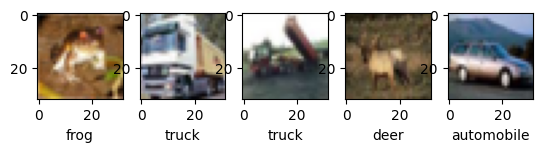

In [5]:
a, ax = plt.subplots(1,5)
for i in range(5):
    ax[i].imshow(Image.open(df.file_path.iloc[i]))
    ax[i].set_xlabel(df.label.iloc[i])
plt.show()

['frog' 'truck' 'deer' 'automobile' 'bird' 'horse' 'ship' 'cat' 'dog'
 'airplane']


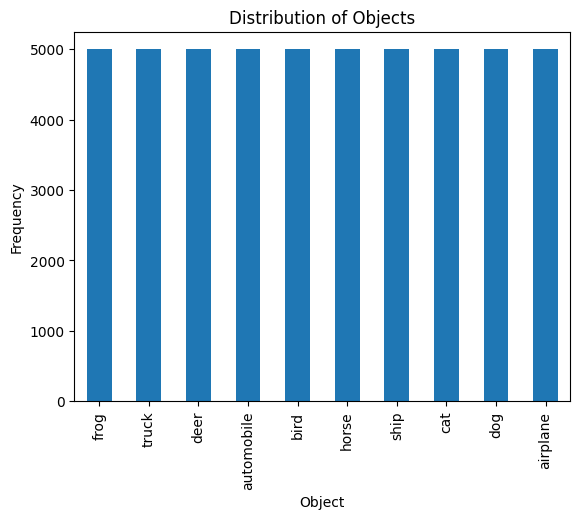

In [6]:
labels = df['label'].unique()
print(labels)
# Visualize the distribution of digits
df['label'].value_counts().plot(kind='bar', title='Distribution of Objects')
plt.xlabel('Object')
plt.ylabel('Frequency')
plt.show()

In [7]:
X = np.ndarray(shape= (df.shape[0],32,32,3))
for i in range(df.shape[0]):
    X[i] = cv2.imread(df.file_path.iloc[i])
dict_label = {
    'frog':0,
    'truck':1,
    'deer':2,
    'automobile':3,
    'bird':4,
    'horse':5,
    'ship':6,
    'cat':7,
    'dog':8,
    'airplane':9
}
y = df['label'].apply(lambda x: dict_label[x])
y.head()

0    0
1    1
2    1
3    2
4    3
Name: label, dtype: int64

In [8]:
X.shape

(50000, 32, 32, 3)

In [9]:
X = X/255
y = to_categorical(y,num_classes = 10)
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,random_state=0)

In [10]:
# CREATE MORE IMAGES VIA DATA AUGMENTATION
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)
datagen.flow(X_train,y_train, batch_size=64),

(<keras.src.preprocessing.image.NumpyArrayIterator at 0x274c6524820>,)

In [10]:
Model = Sequential([
    Conv2D(filters = 32, kernel_size = (3, 3), activation='relu', input_shape = (32, 32, 3)),
    BatchNormalization(),
    Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPool2D(strides=(2,2)),
    Dropout(0.25),
    Conv2D(filters = 64, kernel_size = (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(filters = 64, kernel_size = (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPool2D(strides=(2,2)),
    Dropout(0.25),
    Conv2D(filters = 128, kernel_size = (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(filters = 128, kernel_size = (3, 3), activation='relu'),
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dropout(0.25),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.25),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(10,activation='softmax')])


In [11]:
Model.compile(loss='categorical_crossentropy', optimizer = Adam(learning_rate=1e-4), metrics=["accuracy"])
Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 30, 30, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 28, 28, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                        

In [11]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, verbose=1)

In [13]:
history = Model.fit(datagen.flow(X_train, y_train, batch_size=64),
                           epochs=20,
                           verbose=2,  
                           validation_data=(X_val, y_val), 
                           callbacks=[reduce_lr, early_stopping]).history

Epoch 1/20
440/440 - 74s - loss: 2.0715 - accuracy: 0.2277 - val_loss: 2.4648 - val_accuracy: 0.1571 - lr: 1.0000e-04 - 74s/epoch - 168ms/step
Epoch 2/20
440/440 - 101s - loss: 1.7379 - accuracy: 0.3507 - val_loss: 1.6018 - val_accuracy: 0.4225 - lr: 1.0000e-04 - 101s/epoch - 230ms/step
Epoch 3/20
440/440 - 175s - loss: 1.5969 - accuracy: 0.4124 - val_loss: 1.4901 - val_accuracy: 0.4531 - lr: 1.0000e-04 - 175s/epoch - 397ms/step
Epoch 4/20
440/440 - 141s - loss: 1.5012 - accuracy: 0.4497 - val_loss: 1.4424 - val_accuracy: 0.4753 - lr: 1.0000e-04 - 141s/epoch - 321ms/step
Epoch 5/20
440/440 - 146s - loss: 1.4349 - accuracy: 0.4775 - val_loss: 1.3139 - val_accuracy: 0.5300 - lr: 1.0000e-04 - 146s/epoch - 333ms/step
Epoch 6/20
440/440 - 166s - loss: 1.3842 - accuracy: 0.4997 - val_loss: 1.2776 - val_accuracy: 0.5396 - lr: 1.0000e-04 - 166s/epoch - 378ms/step
Epoch 7/20
440/440 - 155s - loss: 1.3344 - accuracy: 0.5193 - val_loss: 1.4856 - val_accuracy: 0.4962 - lr: 1.0000e-04 - 155s/epoch 

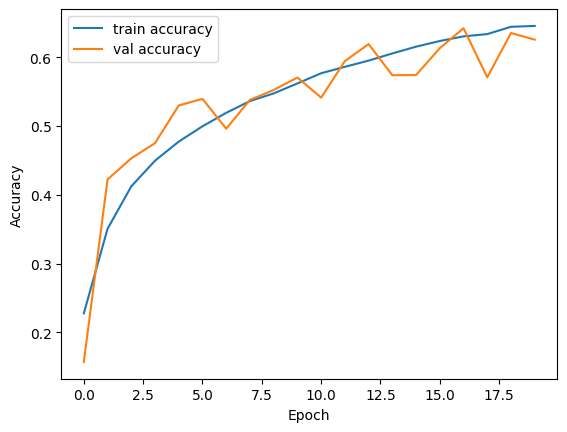

In [14]:
# Plot training and validation accuracy/loss
plt.plot(history['accuracy'], label='train accuracy')
plt.plot(history['val_accuracy'], label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
final_loss, final_acc = Model.evaluate(X_test, y_test, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

Final loss: 1.0885, final accuracy: 0.6313


In [12]:
INPUT = Input(shape=(32,32,3))
vgg_weights = 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
VGG = VGG16(weights=vgg_weights, include_top=False,input_tensor=INPUT)

In [13]:
x = GlobalAveragePooling2D()(VGG.output)
x = Dropout(0.5)(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.5)(x)
FINAL = Dense(10, activation='softmax', name='final_output')(x)
Model = tf.keras.Model(INPUT,FINAL)

In [14]:
Model.compile(loss='categorical_crossentropy', optimizer = Adam(learning_rate=1e-4), metrics=["accuracy"])
Model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [16]:
history = Model.fit(datagen.flow(X_train, y_train, batch_size=64),
                           epochs=20,
                           verbose=1,  
                           validation_data=(X_val, y_val), 
                           callbacks=[reduce_lr, early_stopping]).history

Epoch 1/20
440/440 [==============================] - 1925s 4s/step - loss: 0.8174 - accuracy: 0.7336 - val_loss: 0.6616 - val_accuracy: 0.7795 - lr: 1.0000e-04
Epoch 2/20
440/440 [==============================] - 1899s 4s/step - loss: 0.6411 - accuracy: 0.7915 - val_loss: 0.6222 - val_accuracy: 0.7971 - lr: 1.0000e-04
Epoch 3/20
440/440 [==============================] - 2275s 5s/step - loss: 0.5456 - accuracy: 0.8223 - val_loss: 0.5432 - val_accuracy: 0.8203 - lr: 1.0000e-04
Epoch 4/20
440/440 [==============================] - 2039s 5s/step - loss: 0.4639 - accuracy: 0.8466 - val_loss: 0.5613 - val_accuracy: 0.8229 - lr: 1.0000e-04
Epoch 5/20
440/440 [==============================] - 8861s 20s/step - loss: 0.3874 - accuracy: 0.8740 - val_loss: 0.5491 - val_accuracy: 0.8286 - lr: 1.0000e-04
Epoch 6/20
440/440 [==============================] - 1638s 4s/step - loss: 0.3346 - accuracy: 0.8907 - val_loss: 0.5038 - val_accuracy: 0.8390 - lr: 1.0000e-04
Epoch 7/20
440/440 [=============

In [17]:
Model.save('VGG.py')

INFO:tensorflow:Assets written to: VGG.py\assets


INFO:tensorflow:Assets written to: VGG.py\assets


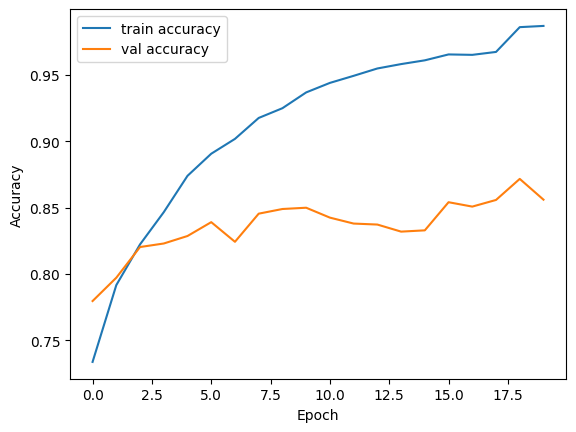

In [18]:
# Plot training and validation accuracy/loss
plt.plot(history['accuracy'], label='train accuracy')
plt.plot(history['val_accuracy'], label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
final_loss, final_acc = Model.evaluate(X_test, y_test, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

Final loss: 0.6770, final accuracy: 0.8560


In [29]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import numpy as np
import cv2
from IPython.display import display
from ipywidgets import widgets

# Assuming the model is named `Model`

# Class names
labels = df['label'].unique()

# Function to preprocess the image
def preprocess_image(filepath):
    img = cv2.imread(filepath)
    img = img / 255.0  # Normalize the image
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Function to classify the image and display the result
def classify_image():
    filepath = filedialog.askopenfilename()
    if filepath:
        img_array = preprocess_image(filepath)
        predicted_class_idx = np.argmax(Model.predict(img_array))
        predicted_class = labels[predicted_class_idx]
        
        # Display the image
        img = Image.open(filepath)
        img = ImageTk.PhotoImage(img)

        # Update the panel with the new image
        panel.config(image=img)
        panel.image = img

        # Display the prediction
        result_label.config(text=f' Predicted Object: {predicted_class} ')

# Create the main window
root = tk.Tk()
root.title("Object Recognizer")
root.geometry("800x600")
root.configure(bg="#f0f0f0")

# Create a title label
title_label = tk.Label(root, text="Object Recognizer", font=("Helvetica", 24, "bold"), bg="#f0f0f0")
title_label.pack(pady=20)

# Create a button to choose an image
choose_button = tk.Button(root, text="Choose an Image", command=classify_image, font=("Helvetica", 16), bg="#4CAF50", fg="white")
choose_button.pack(pady=20)

# Create a label to display the image
panel = tk.Label(root, bg="#f0f0f0")
panel.pack(pady=20)

# Create a label to display the classification result
result_label = tk.Label(root, text="", font=("Helvetica", 20), bg="#f0f0f0")
result_label.pack(pady=20)


root.mainloop()


1/1 [==============================] - 0s 72ms/step
